# Importing Libraries

In [12]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Loading Dataset

In [2]:
df=pd.read_csv("Churn_Modelling.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


EDA and Visualization

In [3]:
df.describe().style.background_gradient(cmap='Blues')
def describe_(df):
    dict_=pd.DataFrame()
    dict_['null_values']=df.isna().sum()
    dict_['unique_']=df.nunique().values  #no of unique values/categories for each feature
    
    return dict_
describe_(df).style.background_gradient(cmap='Blues')
df.drop(['CustomerId','RowNumber','Surname'],axis=1,inplace=True)

<Axes: xlabel='Gender', ylabel='count'>

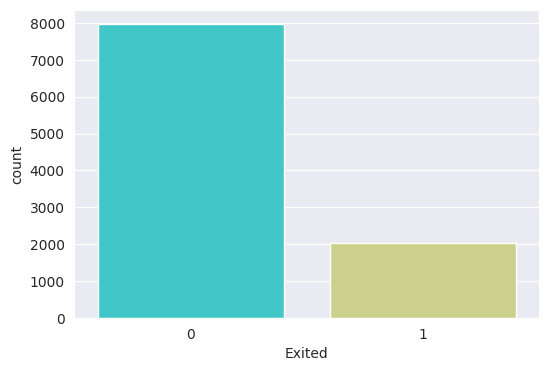

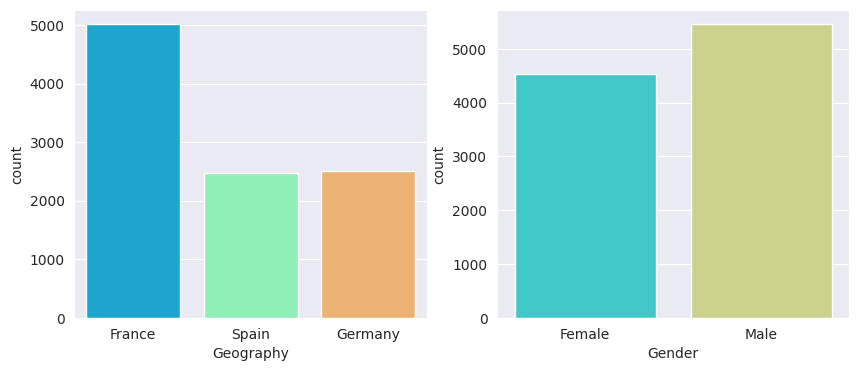

In [4]:
#visualization of the dataset from each category of target variable
plt.figure(figsize=(6,4))
sns.countplot(x='Exited',data=df,palette='rainbow')
fig=plt.figure(figsize=(10,4))
ax=[None for _ in range(2)]
ax[0]=plt.subplot2grid((1,2),(0,0))
ax[1]=plt.subplot2grid((1,2),(0,1))

sns.countplot(x='Geography',data=df,palette='rainbow',ax=ax[0])
sns.countplot(x='Gender',data=df,palette='rainbow',ax=ax[1])

<AxesSubplot:>

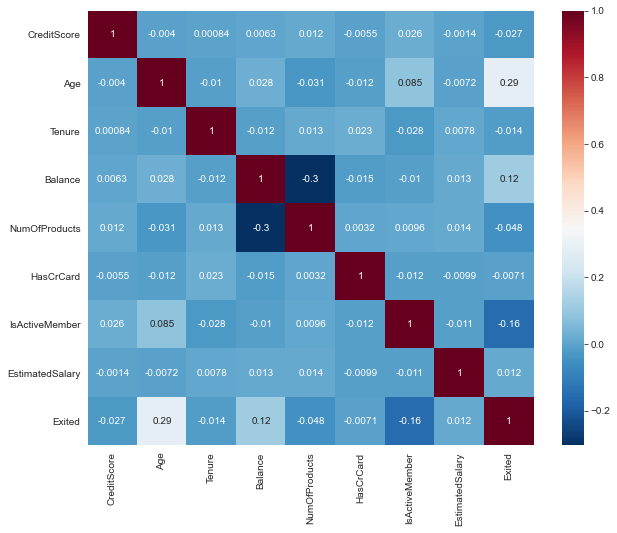

In [4]:
numerical_features=[feature for feature in df.columns if df[feature].dtype!='object']
df_num=df[numerical_features]
plt.figure(figsize=(10,8))
corr=df_num.corr()
sns.heatmap(corr,cmap=plt.cm.RdBu_r,annot=True,annot_kws={'size':10})

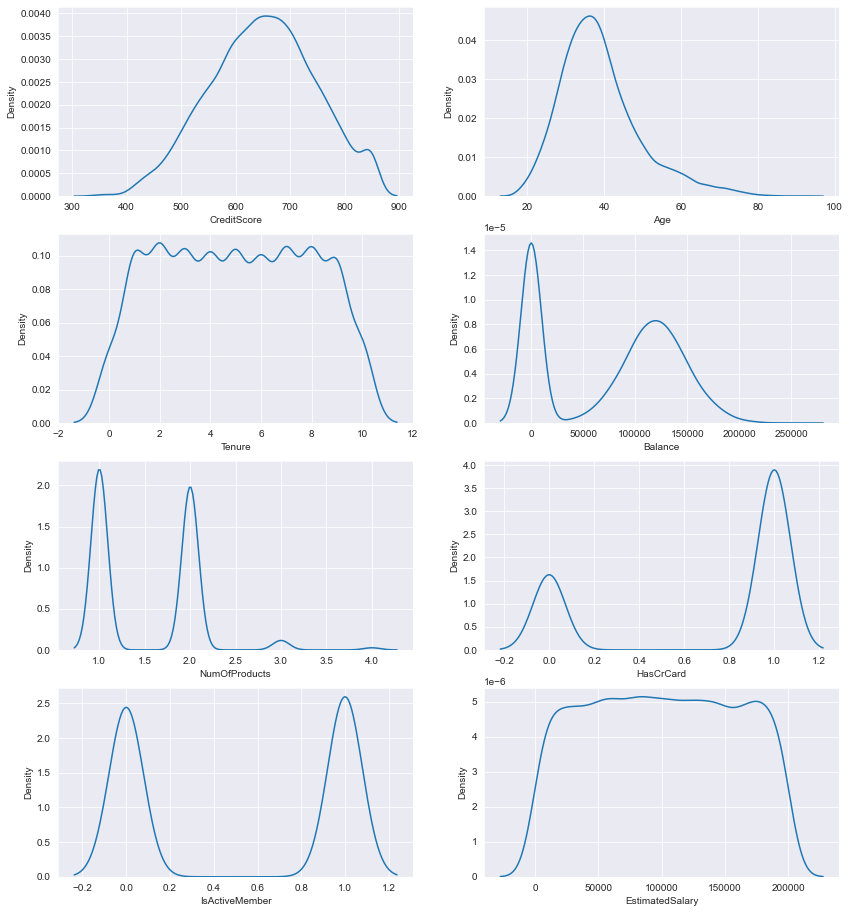

In [5]:
numerical_features.remove('Exited')
fig,ax=plt.subplots(nrows=4,ncols=2,figsize=(14,16))
i=0
for feature in numerical_features:
    n=i//2
    m=i%2
    sns.kdeplot(x=feature,data=df,ax=ax[n,m])
    i+=1

# Data Preprocessing


In [6]:
df_num=df[numerical_features]
df_num=df[numerical_features]
df_cat=df[['Geography','Gender']]

In [7]:
scaler=StandardScaler()
df_num=pd.DataFrame(scaler.fit_transform(df_num),columns=df_num.columns)

In [8]:
encoder=OneHotEncoder()
df_cat=pd.DataFrame(encoder.fit_transform(df_cat).toarray())
df_cat.columns=df_cat.columns.astype(str)

In [9]:
#concating categorical and numerical features
df_=pd.concat([df_num,df_cat],axis=1)
y=df['Exited']

# Random Forest Model

In [13]:
#random forest
forest=RandomForestClassifier()
param_grid = { 
    'n_estimators': [100,200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search=RandomizedSearchCV(estimator=forest,param_distributions=param_grid,cv=3,scoring='roc_auc',n_iter=10,verbose=True)

In [14]:
grid_search.fit(df_,y)
forest=grid_search.best_estimator_
scores_forest=cross_val_score(forest,df_,y,cv=5)
print('Mean value of roc_auc_score for RF Classifier:{}'.format(np.mean(scores_forest)))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mean value of roc_auc_score for RF Classifier:0.8613


# Decision Tree Model

In [15]:
#decision tree classifier
tree=DecisionTreeClassifier()
param_grid={
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search=RandomizedSearchCV(estimator=tree,param_distributions=param_grid,cv=5,scoring='roc_auc',n_iter=10,verbose=True)

In [16]:
grid_search.fit(df_,y)
tree=grid_search.best_estimator_
scores_tree=cross_val_score(tree,df_,y,cv=5)
print('Mean value of roc_auc_score for Dt Classifier:{}'.format(np.mean(scores_tree)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mean value of roc_auc_score for Dt Classifier:0.8522000000000001


# XGB Classifier Model

In [17]:
#xgb classifier
xgb=XGBClassifier()
param_grid={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
grid_search=RandomizedSearchCV(estimator=xgb,param_distributions=param_grid,cv=3,scoring='roc_auc',n_iter=10,verbose=True)

NameError: name 'XGBClassifier' is not defined

In [ ]:
grid_search.fit(df_,y)
xgb=grid_search.best_estimator_
scores_xgb=cross_val_score(xgb,df_,y,cv=5)
print('Mean value of roc_auc_score for XGB Classifier:{}'.format(np.mean(scores_xgb)))